In [1]:
import os
import numpy as np
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from  matplotlib import pyplot as plt

print("tensorflow version" + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
tensorflow version2.15.0


In [2]:
BATCH_SIZE: int = 32
classes: list = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [3]:
#matplotlib configurations
plt.rc('image' , cmap = 'gray')
plt.rc('grid' , linewidth = 0)
plt.rc('xtick', top = False , bottom = False , labelsize = 'large')
plt.rc('ytick' , left = False , right = False  , labelsize = 'large')
plt.rc('axes' , facecolor= 'F8F8F8' , titlesize = "large" , edgecolor = 'white')
plt.rc('text' , color = 'a8151a')

plt.rc('figure' , facecolor = 'F0F0F0')
MATPLOTLIB_FONT_DIR :str = os.path.join(os.path.dirname(plt.__file__),"mpl-data/fonts/ttf")

In [4]:
#to display a rw of digits with their predictions
def display_images(
    digits: np.ndarray,
    predictions: np.ndarray,
    labels: np.ndarray,
    title: str
) -> None:
    n: int = 10
    indexes :np.ndarray= np.random.choice(len(predictions),size = n)
    n_digits: np.ndarray = digits[indexes]
    n_predictions:np.ndarray = predictions[indexes]
    n_predictions = n_predictions.reshape((n,))

    fig:plt.Figure = plt.figure(figsize = (20,4))
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

    for i in range(10):
      fig.add_subplot(1,10 , i+1)
      class_index: np.uint8 = n_predictions[i]

      plt.xlabel(classes[class_index])
      plt.xticks([])
      plt.yticks([])
      plt.imshow(n_digits[i])





In [5]:
#function to display training and validation curves
def plot_metrics(metric_name :str ,  title : str , ylim : int = 5) -> None:
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name] , color = 'blue' , label = metric_name)
  plt.plot(history.history['val_' + metric_name] ,
           color = 'green' , label = f'val_{metric_name}')



In [6]:
training_images: np.ndarray
training_labels: np.ndarray
validation_images: np.ndarray
validation_labels: np.ndarray
(
    training_images, training_labels
) , (
    validation_images, validation_labels
) = tf.keras.datasets.cifar10.load_data()


170498071/170498071 [==============================] - 13s 0us/step


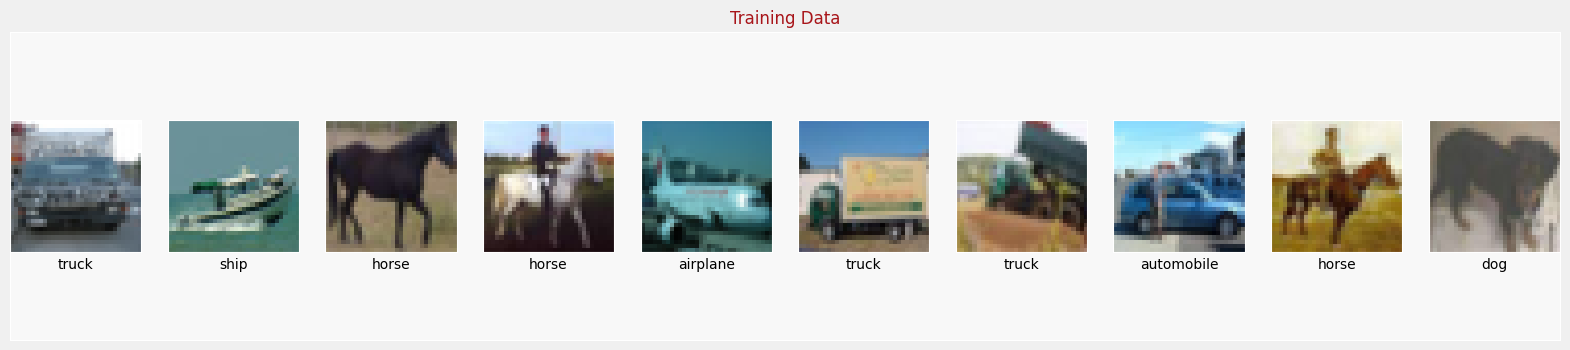

In [7]:
display_images(
    training_images, training_labels , training_labels, "Training Data"
)

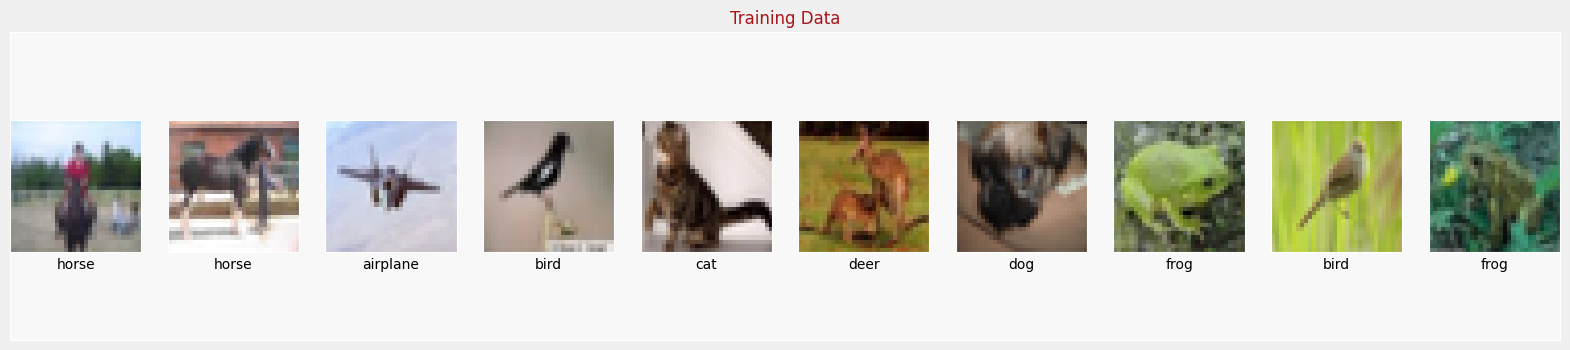

In [8]:
display_images(
    validation_images, validation_labels, validation_labels, "Training Data"
)

In [9]:
validation_images[0].astype('float32').shape


(32, 32, 3)

In [10]:
#preprocessing dataset
def preprocess_image(input_images: np.ndarray) -> np.ndarray:
  input_images = input_images.astype('float32')
  output_ims: np.ndarray = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [11]:
train_X:np.ndarray = preprocess_image(training_images)
Valid_X:np.ndarray = preprocess_image(validation_images)

In [12]:
#performing Transfer Learning: applying ResNet50
#feature_extractor

def feature_extractor(inputs: tf.Tensor) -> tf.Tensor:
  feature_extractor:tf.Tensor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224 , 3), include_top= False  , weights = 'imagenet'  )(inputs)
  return feature_extractor

In [13]:
def classifier(inputs: tf.Tensor) -> tf.Tensor:
  x:tf.Tensor = tf.keras.layers.GlobalAveragePooling2D()(inputs)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024 , activation = "relu")(x)
  x = tf.keras.layers.Dense(512 , activation = "relu")(x)
  x = tf.keras.layers.Dense(10, activation = "softmax" , name = "classification")(x)
  return x

In [14]:
def final_model(inputs:tf.Tensor) -> tf.Tensor:
  resize: tf.Tensor = tf.keras.layers.UpSampling2D(size = (7,7))(inputs)
  resnet_feature_extractor: tf.Tensor = feature_extractor(resize)
  classification_output: tf.Tensor = classifier(resnet_feature_extractor)

  return classification_output

In [15]:
#define model  and compile it
def define_compile_model() -> tf.keras.Model:
  inputs: tf.Tensor = tf.keras.layers.Input(shape = (32,32,3))

  classification_output: tf.Tensor = final_model(inputs)
  model: tf.keras.Model = tf.keras.Model(
      inputs= inputs , outputs = classification_output
  )
  model.compile(
      optimizer = 'SGD',#sgd : stochastic gradient descent
      loss = 'sparse_categorical_crossentropy',#loss function
      metrics  = ['accuracy']


  )
  return model

model:tf.keras.Model = define_compile_model()
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

In [16]:
#training model
EPOCHS : int = 4
history:tf.keras.callbacks.History = model.fit(train_X,
                                               training_labels , epochs = EPOCHS,
                                               validation_data = (Valid_X , validation_labels),batch_size = 64)

Epoch 1/4
782/782 [==============================] - 584s 713ms/step - loss: 0.4023 - accuracy: 0.8694 - val_loss: 0.2218 - val_accuracy: 0.9234
Epoch 2/4
782/782 [==============================] - 556s 711ms/step - loss: 0.1022 - accuracy: 0.9668 - val_loss: 0.1655 - val_accuracy: 0.9450
Epoch 3/4
782/782 [==============================] - 543s 694ms/step - loss: 0.0371 - accuracy: 0.9892 - val_loss: 0.2002 - val_accuracy: 0.9398
Epoch 4/4
782/782 [==============================] - 555s 710ms/step - loss: 0.0149 - accuracy: 0.9964 - val_loss: 0.1851 - val_accuracy: 0.9491


In [17]:
#evaluation of model
loss: float
accuracy : float
loss, accuracy = model.evaluate(Valid_X , validation_labels , batch_size = 64)


157/157 [==============================] - 29s 184ms/step - loss: 0.1851 - accuracy: 0.9491


In [1]:
from  google import colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
model_path = '/content/drive/MyDrive/Advanced Computer vision/model.h5'

# Save the model
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

# Load the saved ResNet-50 model
model = tf.keras.models.load_model('/content/drive/MyDrive/Advanced Computer vision/model.h5')

# Define the image file path
image_path = '/content/drive/MyDrive/airplane.jpeg'

# Load and preprocess the new image
img = image.load_img(image_path, target_size=(32, 32))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Perform inference
predictions = model.predict(x)

# # Define your class labels here
# class_labels = ["class1", "class2", "class3"]  # Replace with your actual class names

# Get the index of the predicted class with the highest probability
predicted_class_index = np.argmax(predictions[0])

# Get the corresponding class name
predicted_class_name = classes[predicted_class_index]

# Get the probability score of the predicted class
predicted_score = predictions[0][predicted_class_index]

# Print the predicted class name and probability score
print("Predicted class:", predicted_class_name)
print("Probability:", predicted_score)


1/1 [==============================] - 4s 4s/step
Predicted class: airplane
Probability: 0.999995
